# CNN Model

## Import Libraries

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from pandasql import sqldf
import time
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.transform import resize

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers


import pydicom
import csv

## Useful functions

In [2]:
#Function to go from numeric label to text label
def n_to_t_label(n_label):
    if n_label == 0:
        t_label = 'noCancer'
    elif n_label == 1:
        t_label = 'withCancer'
    else:
        raise ValueError('Invalid numeric label. Expected 0 or 1, but got {}'.format(n_label))
    return t_label

In [3]:
#ONLY use images that are 4096x3328 but resized
#If this changes, change these variables
im_px_1 = 1024#512
im_px_2 = 832#416

# Def function to plot a mammogram from a vector
# Label will be 'withCancer' or 'noCancer'
def show_mammogram(x_vec, n_label=0):
    label = n_to_t_label(n_label)
    x_mat = x_vec.reshape(im_px_1, im_px_2)
    plt.imshow(x_mat, cmap=plt.cm.gray)
    plt.title('Label of this mammogram is: ' + label)
    plt.show()

In [4]:
## Get matrix of pixels
def v_to_m_image(x_vec, im_px_1=1024, im_px_2=832):
    x_mat = x_vec.reshape(im_px_1, im_px_2,1)
    return x_mat

## Assemble dataframe of images
### Only include images that are 5355 x 4915, resize to 512x416
### One image per patient to start - plan to increase this

In [5]:
# Get df_joined from the file saved in notebook 4
# This data frame has the image file_names, patient_ids, outcomes (cancer or no cancer in 0/1 format and pixel information)
df_joined = pd.read_csv(r"C:\Users\mandy\Documents\MIDS\W207\W207MammogramProject\JoinedData1.csv")
print(df_joined.shape,'\n')
df_joined.head()

(54706, 5) 



,file_name,patient_id,cancer,n_rows_image,n_cols_image
0,1459541791.dcm,10006,0,5355,4915
1,1864590858.dcm,10006,0,5355,4915
2,1874946579.dcm,10006,0,5355,4915
3,462822612.dcm,10006,0,5355,4915
4,1031443799.dcm,10011,0,2776,2082


In [6]:
# Filter to only keep images with 4096 x 3328 pixels
df_filtered = df_joined.loc[(df_joined['n_rows_image'] == 4096) & (df_joined['n_cols_image'] == 3328)].reset_index(drop=True)
print('df_filtered shape:', df_filtered.shape, '\n')
print('df_filtered:\n',df_filtered.head())

df_filtered shape: (24109, 5) 

df_filtered:
         file_name  patient_id  cancer  n_rows_image  n_cols_image
0  1007799858.dcm       10097       0          4096          3328
1   166011602.dcm       10097       0          4096          3328
2  1957744616.dcm       10097       0          4096          3328
3   268368896.dcm       10097       0          4096          3328
4   664674273.dcm       10097       0          4096          3328


In [7]:
# Check how many cancer vs no cancer cases we're left with after the filtering
# 600 cancer cases. No cancer is now ~97% of images vs the pre-filter 98%
# conclusion that this filter returns an ok data set, about half of the original and about the same % split outcomes
df_filtered['cancer'].value_counts()

0    23509
1      600
Name: cancer, dtype: int64

In [8]:
#For the purpose of this exercise, I only want one image per patient
# In practice should do 1 image per breast but simplified for this exercise
#df_filtered = df_filtered.drop_duplicates(subset=['patient_id'], keep='first').reset_index(drop=True)

df_filtered = df_filtered.set_index('file_name')
print(df_filtered)
print('df_filtered cancer value counts:', df_filtered['cancer'].value_counts())
print('\n98% dataset is positive for cancer')

                patient_id  cancer  n_rows_image  n_cols_image
file_name                                                     
1007799858.dcm       10097       0          4096          3328
166011602.dcm        10097       0          4096          3328
1957744616.dcm       10097       0          4096          3328
268368896.dcm        10097       0          4096          3328
664674273.dcm        10097       0          4096          3328
...                    ...     ...           ...           ...
244243187.dcm         9967       0          4096          3328
2098937312.dcm        9968       0          4096          3328
294168046.dcm         9968       0          4096          3328
568005453.dcm         9968       0          4096          3328
766198919.dcm         9968       0          4096          3328

[24109 rows x 4 columns]
df_filtered cancer value counts: 0    23509
1      600
Name: cancer, dtype: int64

98% dataset is positive for cancer


In [9]:
df_filtered.dtypes

patient_id      int64
cancer          int64
n_rows_image    int64
n_cols_image    int64
dtype: object

In [10]:
imageIds = df_filtered.index
print(imageIds)

Index(['1007799858.dcm', '166011602.dcm', '1957744616.dcm', '268368896.dcm',
       '664674273.dcm', '929754876.dcm', '1181635673.dcm', '1241778584.dcm',
       '1245250349.dcm', '1304802631.dcm',
       ...
       '255391556.dcm', '629099099.dcm', '1245697729.dcm', '1260162631.dcm',
       '155474390.dcm', '244243187.dcm', '2098937312.dcm', '294168046.dcm',
       '568005453.dcm', '766198919.dcm'],
      dtype='object', name='file_name', length=24109)


In [11]:
#Get Data
#X is mammogram images
#y is labels

# Set the directory where your DICOM files are located
dicom_directory = r"D:\W207\rsna-breast-cancer-detection\train_images"

# Initialize list of flattened training images and outcomes
images = []
labels = []

# Set a counter for the number of DICOM files found
count = 0

# Start the timer
start_time = time.time()

# Recursively search for DICOM files in all subdirectories
for root, dirs, files in os.walk(dicom_directory):
    for filename in files:
        # Check if the file is a DICOM file
        if filename.endswith(".dcm"):
            # Check if the file is in the training list
            if (imageIds == filename).any().any():
                #print(filename)
                file_path = os.path.join(root, filename)
                # Add the pixel data to X_train_list
                ds = pydicom.dcmread(file_path)
                pixel_array = ds.pixel_array
                resized_pixel_array = resize(pixel_array, (256, 208), anti_aliasing=True)
                images.append(resized_pixel_array.flatten())
                # Add the label information
                labels.append(df_filtered.loc[filename,'cancer'])
            # Increment the counter
            count += 1
            if count % 100 == 0:
                print(f"Processed {count} DICOM files...")
        #if count == 100:
         #   break
    #if count >= 100:
     #   break


images = np.array(images)       

Processed 100 DICOM files...
Processed 200 DICOM files...
Processed 300 DICOM files...
Processed 400 DICOM files...
Processed 500 DICOM files...
Processed 600 DICOM files...
Processed 700 DICOM files...
Processed 800 DICOM files...
Processed 900 DICOM files...
Processed 1000 DICOM files...
Processed 1100 DICOM files...
Processed 1200 DICOM files...
Processed 1300 DICOM files...
Processed 1400 DICOM files...
Processed 1500 DICOM files...
Processed 1600 DICOM files...
Processed 1700 DICOM files...
Processed 1800 DICOM files...
Processed 1900 DICOM files...
Processed 2000 DICOM files...
Processed 2100 DICOM files...
Processed 2200 DICOM files...
Processed 2300 DICOM files...
Processed 2400 DICOM files...
Processed 2500 DICOM files...
Processed 2600 DICOM files...
Processed 2700 DICOM files...
Processed 2800 DICOM files...
Processed 2900 DICOM files...
Processed 3000 DICOM files...
Processed 3100 DICOM files...
Processed 3200 DICOM files...
Processed 3300 DICOM files...
Processed 3400 DICO

Processed 26900 DICOM files...
Processed 27000 DICOM files...
Processed 27100 DICOM files...
Processed 27200 DICOM files...
Processed 27300 DICOM files...
Processed 27400 DICOM files...
Processed 27500 DICOM files...
Processed 27600 DICOM files...
Processed 27700 DICOM files...
Processed 27800 DICOM files...
Processed 27900 DICOM files...
Processed 28000 DICOM files...
Processed 28100 DICOM files...
Processed 28200 DICOM files...
Processed 28300 DICOM files...
Processed 28400 DICOM files...
Processed 28500 DICOM files...
Processed 28600 DICOM files...
Processed 28700 DICOM files...
Processed 28800 DICOM files...
Processed 28900 DICOM files...
Processed 29000 DICOM files...
Processed 29100 DICOM files...
Processed 29200 DICOM files...
Processed 29300 DICOM files...
Processed 29400 DICOM files...
Processed 29500 DICOM files...
Processed 29600 DICOM files...
Processed 29700 DICOM files...
Processed 29800 DICOM files...
Processed 29900 DICOM files...
Processed 30000 DICOM files...
Processe

Processed 53400 DICOM files...
Processed 53500 DICOM files...
Processed 53600 DICOM files...
Processed 53700 DICOM files...
Processed 53800 DICOM files...
Processed 53900 DICOM files...
Processed 54000 DICOM files...
Processed 54100 DICOM files...
Processed 54200 DICOM files...
Processed 54300 DICOM files...
Processed 54400 DICOM files...
Processed 54500 DICOM files...
Processed 54600 DICOM files...
Processed 54700 DICOM files...


In [12]:
import csv
#Save images and labels so don't have to walk through data again
#images
np.savez_compressed('CNN_Xs3.npz', data=images)

#labels
with open('CNN_labels3.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(labels)

In [13]:
#Future: Load the images and labels

# Load the compressed array from disk
#images_mini = np.load('CNN_Xs3.npz')['data']
images_mini = images

# load the labels from disk
with open('CNN_labels3.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]

In [14]:
y_mini= np.array(labels_mini)
print('images_mini.shape:', images_mini.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (24109, 53248)

number of labels: 24109

number of positive cancer cases: 600


## Normalize pixel values to [0,1] range

In [15]:
256*208

53248

In [16]:
print('Original max pixel value:', images_mini.max())
print('Confirm min pixel value is 0:', images_mini.min())

Original max pixel value: 0.062455176623178454
Confirm min pixel value is 0: 0.0


In [17]:
#Normalize image pixel values
images_mini_norm = images_mini / images_mini.max()

In [18]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 1.0
Confirm min pixel value is 0: 0.0


## Make all images 3D instead of 1D

In [19]:
images_mini_norm.shape

(24109, 53248)

In [20]:
n_img,n_pix = images_mini_norm.shape
images_mini_norm = images_mini_norm.reshape(n_img,256,208,1)
images_mini_norm.shape

(24109, 256, 208, 1)

## Visualize image transformations

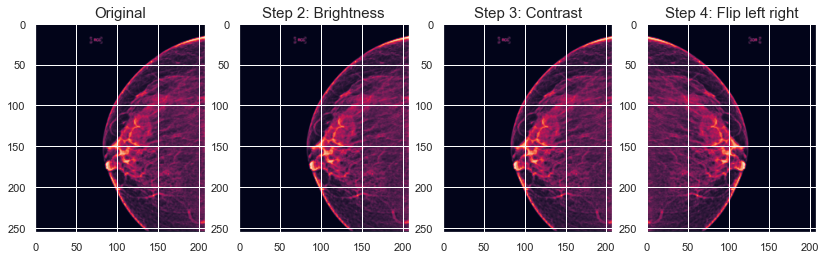

In [21]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini_norm[0]

# plot original
ax = fig.add_subplot(1, 4, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);


# adjust brightness
ax = fig.add_subplot(1, 4, 2)
img_bright = tf.image.adjust_brightness(image, -.8)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 4, 3)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 4, 4)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);


## Split data into train, validate, test

In [22]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; 
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images = images[shuffle]
    y = y[shuffle]
    
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [23]:
y_mini.shape

(24109,)

In [24]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini_norm,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"y_train positive cases {sum(y_train)}\n")

print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"y_val positive cases {sum(y_val)}\n")

print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")
print(f"y_test positive cases {sum(y_test)}\n")

X_train shape (14465, 256, 208, 1)
y_train shape (14465,)
y_train positive cases 367

X_val shape (4821, 256, 208, 1)
y_val shape (4821,)
y_val positive cases 133

X_test shape (4823, 256, 208, 1)
y_test shape (4823,)
y_test positive cases 100



In [25]:
# Augmentation Parameters
CONTRAST_FACTOR = 3
DELTA = 0.3

In [26]:
def preprocess_data_part3(X_train, y_train, CONTRAST_FACTOR, DELTA):
    
    # Augment only cancer=1 data
    X_train_w_cancer = X_train[y_train == 1, :, :, :]
    print(X_train_w_cancer.shape)

    y_train_w_cancer = y_train[y_train == 1]
    print(y_train_w_cancer.shape)
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train_w_cancer, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train_w_cancer
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train

In [27]:
X_train, y_train = preprocess_data_part3(
    X_train, y_train, CONTRAST_FACTOR, DELTA)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

(367, 256, 208, 1)
(367,)
X_train shape (14832, 256, 208, 1)
y_train shape (14832,)
X_val shape (4821, 256, 208, 1)
y_val shape (4821,)
X_test shape (4823, 256, 208, 1)
y_test shape (4823,)


## Build model

In [28]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 256, 208, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 256, 208, 32)      832       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 128, 104, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 128, 104, 64)      51264     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 64, 52, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 212992)            0         
_________________________________________________________________
fc_1 (Dense)                 (None, 1024)              218104832 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

In [30]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=3, 
                    validation_data=(X_val, y_val)
)

Epoch 1/3
464/464 [==============================] - 1278s 3s/step - loss: 0.1793 - accuracy: 0.9569 - val_loss: 0.1360 - val_accuracy: 0.9724
Epoch 2/3
464/464 [==============================] - 1278s 3s/step - loss: 0.1241 - accuracy: 0.9746 - val_loss: 0.1327 - val_accuracy: 0.9724
Epoch 3/3
464/464 [==============================] - 1269s 3s/step - loss: 0.1211 - accuracy: 0.9746 - val_loss: 0.1331 - val_accuracy: 0.9724


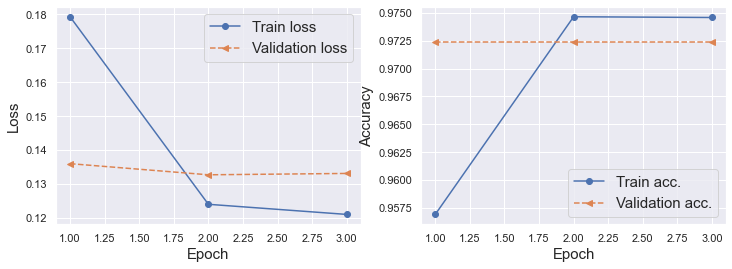

In [31]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()